In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.class_weight import compute_class_weight

%matplotlib inline

# Data Preprocessing

In [152]:
data = pd.read_csv('./Traffic_accidents.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4265 entries, 0 to 4264
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   OBJECTID              4265 non-null   int64 
 1   DATE_                 4265 non-null   object
 2   TIME                  4265 non-null   int64 
 3   SEVERITY              4265 non-null   int64 
 4   SEVERITY_DESCRIPTION  4265 non-null   object
 5   ACCIDENT_TYPE         4265 non-null   object
 6   ACCIDENT_DESCRIPTION  4265 non-null   object
 7   VEHICLES              4265 non-null   int64 
 8   CASUALTIES            4265 non-null   int64 
 9   PEDESTRIAN            4265 non-null   int64 
 10  CYCLES                4265 non-null   int64 
 11  MCYCLES               4265 non-null   int64 
 12  CHILDREN              4265 non-null   int64 
 13  OAPS                  4265 non-null   int64 
 14  X                     4265 non-null   int64 
 15  Y                     4265 non-null   

In [153]:
data.head(3)

OBJECTID                   DATE_  TIME  SEVERITY SEVERITY_DESCRIPTION  \
0         1  2017/02/02 00:00:00+00   720         3               Slight   
1         2  2017/02/02 00:00:00+00  1803         3               Slight   
2         3  2017/02/03 00:00:00+00  2021         3               Slight   

  ACCIDENT_TYPE                      ACCIDENT_DESCRIPTION  VEHICLES  \
0            LC                           Loss of Control         2   
1             J  Turning movement ¿ unidentified priority         2   
2            J2          Turning Movement from minor road         2   

   CASUALTIES  PEDESTRIAN  CYCLES  MCYCLES  CHILDREN  OAPS       X       Y  \
0           2           0       1        1         0     0  360035  175918   
1           1           0       1        0         0     0  359039  172053   
2           1           0       1        0         0     0  362596  175377   

  RENDER  
0    CYC  
1    CYC  
2    CYC

In [154]:
data.isnull().sum()

OBJECTID                0
DATE_                   0
TIME                    0
SEVERITY                0
SEVERITY_DESCRIPTION    0
ACCIDENT_TYPE           0
ACCIDENT_DESCRIPTION    0
VEHICLES                0
CASUALTIES              0
PEDESTRIAN              0
CYCLES                  0
MCYCLES                 0
CHILDREN                0
OAPS                    0
X                       0
Y                       0
RENDER                  0
dtype: int64

<Axes: >

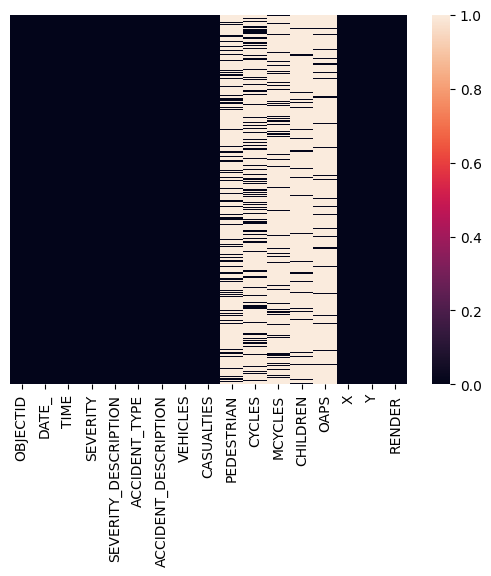

In [155]:
sns.heatmap(data == 0, yticklabels=False)

In [156]:
pd.get_dummies(data["SEVERITY"])

1      2      3
0     False  False   True
1     False  False   True
2     False  False   True
3     False  False   True
4     False  False   True
...     ...    ...    ...
4260  False  False   True
4261  False   True  False
4262  False  False   True
4263  False  False   True
4264  False  False   True

[4265 rows x 3 columns]

In [157]:
new_severity = pd.get_dummies(data["SEVERITY"])

In [158]:
data=pd.concat([data,new_severity],axis=1)
data.head(3)

OBJECTID                   DATE_  TIME  SEVERITY SEVERITY_DESCRIPTION  \
0         1  2017/02/02 00:00:00+00   720         3               Slight   
1         2  2017/02/02 00:00:00+00  1803         3               Slight   
2         3  2017/02/03 00:00:00+00  2021         3               Slight   

  ACCIDENT_TYPE                      ACCIDENT_DESCRIPTION  VEHICLES  \
0            LC                           Loss of Control         2   
1             J  Turning movement ¿ unidentified priority         2   
2            J2          Turning Movement from minor road         2   

   CASUALTIES  PEDESTRIAN  CYCLES  MCYCLES  CHILDREN  OAPS       X       Y  \
0           2           0       1        1         0     0  360035  175918   
1           1           0       1        0         0     0  359039  172053   
2           1           0       1        0         0     0  362596  175377   

  RENDER      1      2     3  
0    CYC  False  False  True  
1    CYC  False  False  True  
2    CYC  False  False  True

In [159]:
data.drop(['OBJECTID','DATE_','TIME','SEVERITY','SEVERITY_DESCRIPTION', 'CASUALTIES', 'ACCIDENT_TYPE','ACCIDENT_DESCRIPTION', 'X', 'Y', 'RENDER'],axis=1,inplace=True)
data.head(3)

VEHICLES  PEDESTRIAN  CYCLES  MCYCLES  CHILDREN  OAPS      1      2     3
0         2           0       1        1         0     0  False  False  True
1         2           0       1        0         0     0  False  False  True
2         2           0       1        0         0     0  False  False  True

In [160]:
data.rename(columns={1: 'Fatal',2: 'Severe', 3: 'Slight'}, inplace=True)

In [161]:
data.head(3)

VEHICLES  PEDESTRIAN  CYCLES  MCYCLES  CHILDREN  OAPS  Fatal  Severe  \
0         2           0       1        1         0     0  False   False   
1         2           0       1        0         0     0  False   False   
2         2           0       1        0         0     0  False   False   

   Slight  
0    True  
1    True  
2    True

# Performance Evaluation Functions

In [162]:
def plot_dataset(X, y, axes):
    plt.plot(X[:,0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:,0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$Age$", fontsize=15)
    plt.ylabel(r"$Glucose$", fontsize=15, rotation=90)

In [163]:
results = []
def add_results(result):
    results.append(result)
    
def get_results():
    print("Model, Test Avg. Accuracy, Test Avg. Precision")
    return results

In [164]:
def evaluate_model(model):
    y_pred = model.predict(X_test)
    matrix = multilabel_confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    accu_score = accuracy_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)
    print("\nConfusion Matrix:")
    print(matrix)
    print("\nClassification Report:")
    print(class_report)
    print("\nAccuracy Score")
    print(accu_score)
    print("\n")
    print('\nAverage accuracy: ', np.mean(scores))

    # doing k fold cross validation for precision
    scores_test = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=10)

    print('\nTest average accuracy: ', np.mean(scores_test))

    scores = cross_val_score(model, X_train, y_train, scoring='precision_macro', cv=10)
    # print the average score
    print('\nAverage precision: ', scores.mean())

    # doing k fold cross validation for accuracy
    scores_test = cross_val_score(model, X_test, y_test, scoring='precision_macro', cv=10)

    print('\nTest average precision: ', scores_test.mean())

<h1> Splitting dataset </h1>

In [165]:
X = data.drop(['Fatal','Severe','Slight'], axis=1)
y = data[['Fatal','Severe','Slight']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

<h1> Support Vector Machine </h1>

In [166]:
linear_model = SVC(kernel='linear', class_weight='balanced')
rbf_model = SVC(kernel='rbf',class_weight='balanced')
poly_model = SVC(kernel='poly', class_weight='balanced')
linear_pipeline = make_pipeline(StandardScaler(), OneVsRestClassifier(linear_model))
rbf_pipeline = make_pipeline(StandardScaler(), OneVsRestClassifier(rbf_model))
poly_pipeline = make_pipeline(StandardScaler(), OneVsRestClassifier(poly_model))

In [167]:
linear_pipeline.fit(X_train, y_train)
rbf_pipeline.fit(X_train, y_train)
poly_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=SVC(class_weight='balanced',
                                                   kernel='poly')))])

In [168]:
print("Linear Kernel:")
evaluate_model(model=linear_pipeline)


Linear Kernel:


Confusion Matrix:
[[[429 843]
  [  2   6]]

 [[814 354]
  [ 51  61]]

 [[ 64  56]
  [351 809]]]

Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.75      0.01         8
           1       0.15      0.54      0.23       112
           2       0.94      0.70      0.80      1160

   micro avg       0.41      0.68      0.51      1280
   macro avg       0.36      0.66      0.35      1280
weighted avg       0.86      0.68      0.74      1280
 samples avg       0.48      0.68      0.55      1280


Accuracy Score
0.278125



Average accuracy:  0.4732621041054073

Test average accuracy:  0.56640625

Average precision:  0.3535586278778559

Test average precision:  0.36008859940766724


In [169]:
print("Rbf Kernel:")
evaluate_model(model=rbf_pipeline)


Rbf Kernel:


Confusion Matrix:
[[[954 318]
  [  3   5]]

 [[801 367]
  [ 44  68]]

 [[ 72  48]
  [367 793]]]

Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.62      0.03         8
           1       0.16      0.61      0.25       112
           2       0.94      0.68      0.79      1160

   micro avg       0.54      0.68      0.60      1280
   macro avg       0.37      0.64      0.36      1280
weighted avg       0.87      0.68      0.74      1280
 samples avg       0.63      0.68      0.65      1280


Accuracy Score
0.58984375



Average accuracy:  0.5695259365670805

Test average accuracy:  0.62265625

Average precision:  0.3577150304309214

Test average precision:  0.3608131411222749


In [170]:
print("Polynomial Kernel:")
evaluate_model(model=poly_pipeline)

Polynomial Kernel:


Confusion Matrix:
[[[1093  179]
  [   3    5]]

 [[ 808  360]
  [  49   63]]

 [[  68   52]
  [ 388  772]]]

Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.62      0.05         8
           1       0.15      0.56      0.24       112
           2       0.94      0.67      0.78      1160

   micro avg       0.59      0.66      0.62      1280
   macro avg       0.37      0.62      0.36      1280
weighted avg       0.86      0.66      0.73      1280
 samples avg       0.63      0.66      0.64      1280


Accuracy Score
0.59921875



Average accuracy:  0.5658357837085587

Test average accuracy:  0.62734375

Average precision:  0.35523246056738833

Test average precision:  0.3639164795461743
